## study_styletransfer.ipynb

In [6]:
!pip install tensorflow

  Using cached tensorflow-2.5.0-cp38-cp38-win_amd64.whl (422.6 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached grpcio-1.34.1-cp38-cp38-win_amd64.whl (2.9 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached h5py-3.1.0-cp38-cp38-win_amd64.whl (2.7 MB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached wrapt-1.12.1.tar.gz (27 kB)
  Using cached keras_nightly-2.5.0.dev2021032900-py2.py3-none-any.whl (1.2 MB)
  Using cached absl_py-0.13.0-py3-none-any.whl (132 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorboard-2.5.0-py3-none-any.whl (6.0 MB)
  Using cached tensorflow_estimator-2.5.0-py2.py3-none-any.whl (462 kB)
  Using cached google_auth_oau

You should consider upgrading via the 'c:\20210710\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [ ]:
network = tf.keras.applications.VGG19(include_top = False, weights = "imagenet")

In [ ]:
network.summary()

In [ ]:
len(network.layers)

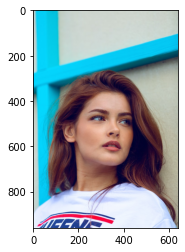

In [13]:
content_image = tf.keras.preprocessing.image.load_img("g2.jpg")
plt.imshow(content_image)

In [14]:
type(content_image)

PIL.JpegImagePlugin.JpegImageFile

In [15]:
content_image = tf.keras.preprocessing.image.img_to_array(content_image)

In [16]:
type(content_image), content_image.shape, content_image.min(), content_image.max()

(numpy.ndarray, (960, 640, 3), 0.0, 255.0)

In [17]:
content_image = content_image / 255

In [18]:
content_image.min(), content_image.max()

(0.0, 1.0)

In [ ]:
content_image

In [20]:
content_image = content_image[tf.newaxis, :]

In [21]:
content_image.shape

(1, 960, 640, 3)

In [52]:
style_image = tf.keras.preprocessing.image.load_img("tarsila_amaral.jpg")

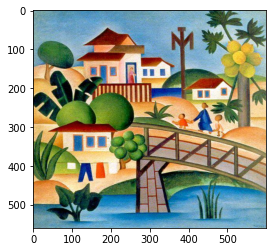

In [53]:
plt.imshow(style_image)

In [54]:
style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image / 255
style_image = style_image[tf.newaxis, :]
style_image.shape

(1, 560, 600, 3)

In [55]:
content_layers = ["block4_conv2"]
style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]

In [56]:
[network.get_layer(name).output for name in style_layers]

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [57]:
network.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

In [58]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top = False, weights = "imagenet")
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    network = tf.keras.Model(inputs = [vgg.input], outputs = outputs)

    return network

In [59]:
style_extractor = vgg_layers(style_layers)

In [60]:
style_extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [61]:
len(style_extractor.layers)

18

In [62]:
style_extractor.outputs

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [63]:
style_outputs = style_extractor(style_image)

In [64]:
len(style_outputs)

5

In [65]:
style_outputs[1]

<tf.Tensor: shape=(1, 280, 300, 128), dtype=float32, numpy=
array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          7.1451001e+00, 0.0000000e+00, 1.2458383e+01],
         [0.0000000e+00, 0.0000000e+00, 1.6780980e+00, ...,
          2.6414454e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 1.1416001e+00, ...,
          5.3857527e+00, 0.0000000e+00, 1.1649452e+00],
         ...,
         [0.0000000e+00, 0.0000000e+00, 1.7971697e+00, ...,
          5.8314395e+00, 0.0000000e+00, 1.2675005e+00],
         [0.0000000e+00, 0.0000000e+00, 2.0207396e+00, ...,
          6.5748844e+00, 0.0000000e+00, 2.6461127e+00],
         [0.0000000e+00, 0.0000000e+00, 7.9473062e+00, ...,
          1.3143226e+01, 0.0000000e+00, 0.0000000e+00]],

        [[0.0000000e+00, 4.9902220e+00, 0.0000000e+00, ...,
          7.3128695e+00, 5.7628685e-01, 1.3347646e+01],
         [0.0000000e+00, 5.0576692e+00, 7.9425313e-02, ...,
          0.0000000e+00, 3.5877329e-01, 0.0000000e+0

In [66]:
style_outputs[0].shape, style_outputs[1].shape, style_outputs[2].shape, style_outputs[3].shape, style_outputs[4].shape 

(TensorShape([1, 560, 600, 64]),
 TensorShape([1, 280, 300, 128]),
 TensorShape([1, 140, 150, 256]),
 TensorShape([1, 70, 75, 512]),
 TensorShape([1, 35, 37, 512]))

In [67]:
def gram_matrix(layer_activation):
    result = tf.linalg.einsum("bijc, bijd->bcd", layer_activation, layer_activation)
    input_shape = tf.shape(layer_activation)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

    return result / num_locations

In [68]:
gram_matrix(style_outputs[0])

<tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
array([[[0.6309873 , 0.28931645, 0.2851602 , ..., 0.10537571,
         0.369587  , 0.45012602],
        [0.28931645, 0.24121155, 0.18381076, ..., 0.03157695,
         0.1959414 , 0.2171576 ],
        [0.2851602 , 0.18381076, 0.16743274, ..., 0.02779872,
         0.1941035 , 0.22709455],
        ...,
        [0.10537571, 0.03157695, 0.02779872, ..., 0.0829746 ,
         0.06948005, 0.06642946],
        [0.369587  , 0.1959414 , 0.1941035 , ..., 0.06948005,
         0.2868263 , 0.31854072],
        [0.45012602, 0.2171576 , 0.22709455, ..., 0.06642946,
         0.31854072, 0.37468502]]], dtype=float32)>

In [69]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        input = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.prorpcess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs = outputs[:self.num_style_layers]
        content_outputs = outputs[self.num_style_layers:]

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {
            content_name : value for content_name,
            value in zip(self.content_layers, content_outputs)
        }
        style_dict = {
            style_name : value for style_name,
            value in zip(self.style_layers, style_outputs)
        }
        return {"content": content_dict, "style": style_dict}
